MODEL TRAINING AND TESTING

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
import os

In [8]:
# File path

result_dir = os.path.join('..', 'Outputs', 'RA_results')
target_dir = os.path.join('..', 'Final Datasets', 'RA_final')
raw_file_dir = os.path.join('..', 'Raw_Datasets', 'RA_data')

# Final File path 
snp_file = os.path.join(raw_file_dir, 'RA_top10000_cleaned.csv')
pheno_final_extended = os.path.join(target_dir, 'RA_aligned_phenotypes_final_extended.csv')
pheno_final_path = os.path.join(target_dir, 'RA_aligned_phenotypes_final.csv') 
geno_final_path = os.path.join(target_dir, 'RA_aligned_genotypes_final.csv')
logreg_model = os.path.join(result_dir, 'RA_selectKbest_logreg_model.joblib')
logreg_coeff = os.path.join(result_dir, 'logreg_selectKbest_coefficients.csv')
logreg_model_AS = os.path.join(result_dir, 'RA_selectKbest_logreg_model_AgeSex.joblib')
logreg_coeff_AS = os.path.join(result_dir, 'logreg_selectKbest_coefficients_AgeSex.csv')
model_perf = os.path.join(result_dir, 'RA_selectKbest_model_performance.png')
model_perf_AS = os.path.join(result_dir, 'RA_selectKbest_model_performance_ageSex.png')
cf_matrix = os.path.join(result_dir, 'RA_confusion_matrix.png')
prs_csv = os.path.join(result_dir, 'RA_prs_scores.csv')
prs_png = os.path.join(result_dir, 'RA_PRS_distribution_fixed.png')

In [9]:
# Step 1: Load data
X = pd.read_csv(geno_final_path, index_col=0)
y = pd.read_csv(pheno_final_path).set_index("sample_id")["label"]

# Step 2: Align samples
common = X.index.intersection(y.index)
X = X.loc[common]
y = y.loc[common]


selector = SelectKBest(score_func=f_classif, k=80)
X_selected = selector.fit_transform(X, y)

# Retain column names
selected_snps = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, index=X.index, columns=selected_snps)

In [10]:
# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_df, y, test_size=0.10, stratify=y, random_state=42
)

In [11]:
# Step 5: Train Logistic Regression with L1 penalty
print("Training LogisticRegressionCV...")
logreg = LogisticRegressionCV(
    Cs=10,
    cv=10,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=10000,
    n_jobs=2,
    random_state=42
).fit(X_train, y_train)

Training LogisticRegressionCV...


Train AUC: 0.618
Test AUC: 0.540

Accuracy (threshold 0.5): 0.558

Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.56      0.56       126
           1       0.56      0.55      0.55       125

    accuracy                           0.56       251
   macro avg       0.56      0.56      0.56       251
weighted avg       0.56      0.56      0.56       251



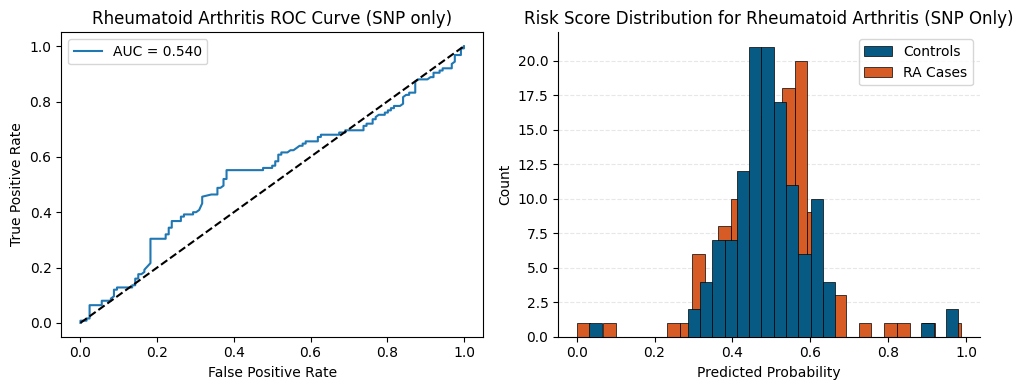


Confusion Matrix (threshold = 0.5):
[[71 55]
 [56 69]]


In [12]:
# Prediction and evaluation
y_pred_prob_train = logreg.predict_proba(X_train)[:, 1]
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_prob_train)
test_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

y_pred_binary = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy (threshold 0.5): {accuracy:.3f}")

# Step 3: Optional detailed report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_binary))

# Step 7: Save model and coefficients
joblib.dump(logreg, logreg_model)
pd.Series(logreg.coef_.flatten(), index=X_selected_df.columns, name="coefficients")\
  .to_csv(logreg_coeff)

# Step 8: Visualize ROC and Risk Score Distribution
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 4))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Rheumatoid Arthritis ROC Curve (SNP only)")
plt.legend()

# Risk Score Histogram
plt.subplot(1, 2, 2)
plt.hist(y_pred_prob[y_test == 0], bins=30, alpha=1, label="Controls", color="#065a83", edgecolor='black', linewidth=0.5, zorder=3)
plt.hist(y_pred_prob[y_test == 1], bins=30, alpha=1, label="RA Cases", color="#d75b25", edgecolor='black', linewidth=0.5, zorder=2)
plt.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Risk Score Distribution for Rheumatoid Arthritis (SNP Only)")
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(model_perf, dpi=500, bbox_inches='tight')
plt.show()

# Step 9: Confusion Matrix
print("\nConfusion Matrix (threshold = 0.5):")
print(confusion_matrix(y_test, y_pred_prob > 0.5))


In [13]:
#Taking only Age And Sex

# 1. Load phenotypes (has age, sex, label)
df = pd.read_csv(pheno_final_extended).set_index("sample_id")

# 2. Define age+sex as features, label as target
df["sex"] = df["sex"].map({"M":0, "F":1})
X_age_sex = df[["age", "sex"]]
y = df["label"]

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(
    X_age_sex, y, stratify=y, test_size=0.10, random_state=42
)

# 4. Train and Evaluate
model = LogisticRegressionCV(Cs=10, cv=10, penalty='l1', solver='saga', max_iter=10000, n_jobs=2, random_state=42)
model.fit(X_train, y_train)

auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"Age + Sex Only AUC: {auc:.3f}")

Age + Sex Only AUC: 0.519


In [14]:
#Taking sex and age as covariates

X = pd.read_csv(geno_final_path, index_col=0)
phenos = pd.read_csv(pheno_final_extended).set_index("sample_id")

common = X.index.intersection(phenos.index)
X = X.loc[common]
phenos = phenos.loc[common]

phenos["sex_bin"] = phenos["sex"].map({"M":0, "F":1})

y = phenos["label"]
age = phenos["age"]
sex = phenos["sex_bin"]

In [15]:
selector = SelectKBest(score_func=f_classif, k=80)
X_selected = selector.fit_transform(X, y)
selected_snps = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, index=X.index, columns=selected_snps)

X_selected_df["age"] = age
X_selected_df["sex"] = sex

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_df, y, test_size=0.10, stratify=y, random_state=42
)

In [17]:
print("Training LogisticRegressionCV...")
logreg = LogisticRegressionCV(
    Cs=10,
    cv=10,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=10000,
    n_jobs=2,
    random_state=42
).fit(X_train, y_train)

Training LogisticRegressionCV...


Train AUC: 0.622
Test AUC: 0.529

Accuracy (threshold 0.5): 0.550

Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.56      0.55       126
           1       0.55      0.54      0.55       125

    accuracy                           0.55       251
   macro avg       0.55      0.55      0.55       251
weighted avg       0.55      0.55      0.55       251



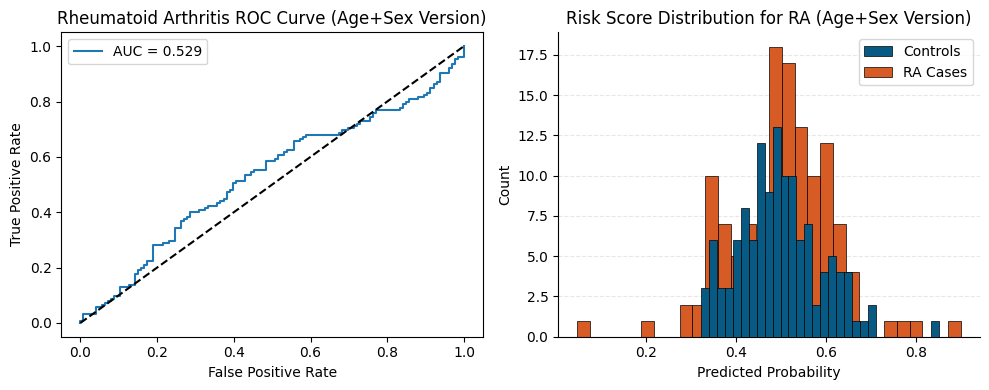


Confusion Matrix (threshold = 0.5):
[[70 56]
 [57 68]]


In [18]:
# Prediction and evaluation
y_pred_prob_train = logreg.predict_proba(X_train)[:, 1]
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_prob_train)
test_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

y_pred_binary = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy (threshold 0.5): {accuracy:.3f}")

# Step 3: Optional detailed report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_binary))

# Step 7: Save model and coefficients
joblib.dump(logreg, logreg_model_AS)
pd.Series(logreg.coef_.flatten(), index=X_selected_df.columns, name="coefficients")\
  .to_csv(logreg_coeff_AS)

# Step 8: Visualize ROC and Risk Score Distribution
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 4))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Rheumatoid Arthritis ROC Curve (Age+Sex Version)")
plt.legend()

# Risk Score Histogram
plt.subplot(1, 2, 2)
plt.hist(y_pred_prob[y_test == 0], bins=30, alpha=1, label="Controls", color="#065a83", edgecolor='black', linewidth=0.5, zorder=3)
plt.hist(y_pred_prob[y_test == 1], bins=30, alpha=1, label="RA Cases", color="#d75b25", edgecolor='black', linewidth=0.5, zorder=2)
plt.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Risk Score Distribution for RA (Age+Sex Version)")
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(model_perf_AS, dpi=500, bbox_inches='tight')
plt.show()

# Step 9: Confusion Matrix
print("\nConfusion Matrix (threshold = 0.5):")
print(confusion_matrix(y_test, y_pred_prob > 0.5))

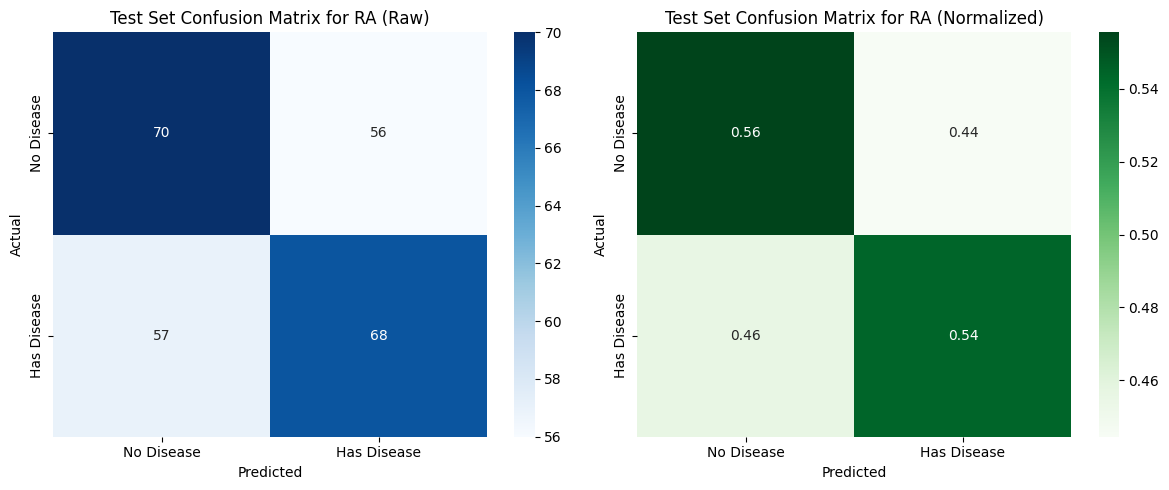

In [19]:
# Predicted labels using threshold 0.5
y_pred_label = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix - Raw
cm_raw = confusion_matrix(y_test, y_pred_label)

# Confusion Matrix - Normalized
cm_normalized = confusion_matrix(y_test, y_pred_label, normalize='true')

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw Confusion Matrix
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Test Set Confusion Matrix for RA (Raw)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Disease', 'Has Disease'])
axes[0].set_yticklabels(['No Disease', 'Has Disease'])

# Normalized Confusion Matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', ax=axes[1])
axes[1].set_title('Test Set Confusion Matrix for RA (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['No Disease', 'Has Disease'])
axes[1].set_yticklabels(['No Disease', 'Has Disease'])

plt.tight_layout()
plt.savefig(cf_matrix, dpi=300)
plt.show()

PRS Score calculation


SNPs in coefficients file: 80
Overlap in X genotype matrix: 80


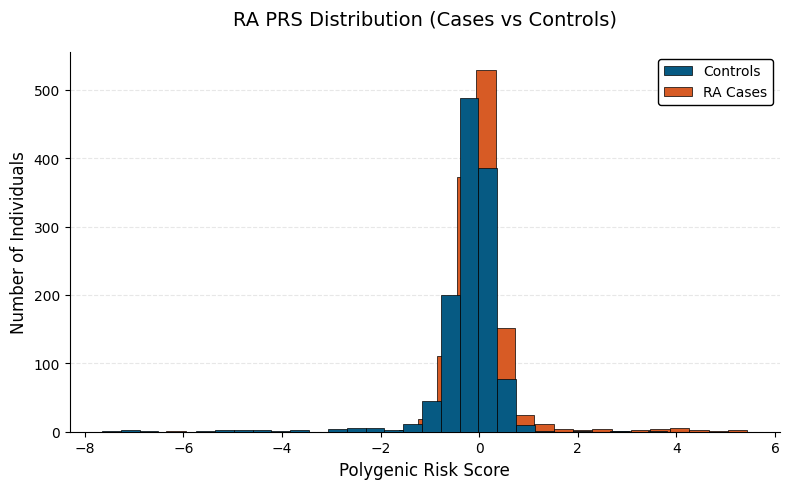

In [20]:
X = pd.read_csv(geno_final_path, index_col=0)
phenos = pd.read_csv(pheno_final_path).set_index("sample_id")

model = joblib.load(logreg_model)
coef = pd.read_csv(logreg_coeff, index_col=0)
coef = coef.squeeze()

selected_snps = coef.index.tolist()
X_prs = X[selected_snps]

prs_scores = X_prs.dot(coef)
prs_df = phenos[["label"]].copy()
prs_df["PRS"] = prs_scores

print("\nSNPs in coefficients file:", len(selected_snps))
print("Overlap in X genotype matrix:", X.columns.intersection(selected_snps).shape[0])

prs_df.to_csv(prs_csv)


#Histogram plotting
case_color = "#d75b25"      
control_color = "#065a83"    

plt.figure(figsize=(8, 5), dpi=100)

plt.hist(
    prs_df[prs_df["label"] == 0]["PRS"],
    bins=30,
    alpha=1,
    label="Controls",
    color=control_color,
    edgecolor='black',
    linewidth=0.5,
    zorder=3
)

plt.hist(
    prs_df[prs_df["label"] == 1]["PRS"],
    bins=30,
    alpha=1,
    label="RA Cases",
    color=case_color,
    edgecolor='black',
    linewidth=0.5,
    zorder=2
)

plt.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)

plt.title("RA PRS Distribution (Cases vs Controls)", fontsize=14, pad=20)
plt.xlabel("Polygenic Risk Score", fontsize=12)
plt.ylabel("Number of Individuals", fontsize=12)
plt.legend(framealpha=1, edgecolor='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(prs_png, dpi=500, bbox_inches='tight')
plt.show()


In [21]:
# Top 10% threshold taken
prs_threshold = prs_df["PRS"].quantile(0.90)

# Counting individuals above it
high_risk = prs_df[prs_df["PRS"] >= prs_threshold]

# Splitting by label
high_risk_cases = high_risk[high_risk["label"] == 1].shape[0]
high_risk_controls = high_risk[high_risk["label"] == 0].shape[0]

print(f"Top 10% PRS threshold: {prs_threshold:.3f}")
print(f"RA Cases in top 10%: {high_risk_cases}")
print(f"Controls in top 10%: {high_risk_controls}")


Top 10% PRS threshold: 0.389
RA Cases in top 10%: 170
Controls in top 10%: 81


In [22]:
model = joblib.load(logreg_model)  

# Best C chosen by CV
C_star = model.C_[0]               
lambda_star = 1 / C_star           

print(f"Best C (C*): {C_star}")
print(f"Regularization Strength λ* = {lambda_star:.2e}")


Best C (C*): 10000.0
Regularization Strength λ* = 1.00e-04
